In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
# Load the CSV files
train_df = pd.read_csv(r"E:\Machine Learning\lacuna-malaria-detection-challenge\Train.csv")
test_df = pd.read_csv(r"E:\Machine Learning\lacuna-malaria-detection-challenge\Test.csv")

In [3]:
# Select 600 images from each class
balanced_train_df = train_df.groupby('class').apply(lambda x: x.sample(n=600, random_state=42)).reset_index(drop=True)

# Split the balanced dataset into training and validation sets
train_data, val_data = train_test_split(balanced_train_df, test_size=0.2, random_state=42, stratify=balanced_train_df['class'])

/tmp/ipykernel_23/87572859.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_train_df = train_df.groupby('class').apply(lambda x: x.sample(n=600, random_state=42)).reset_index(drop=True)


In [4]:
# Reset index for both dataframes
train_data = train_data.reset_index(drop=True)
val_data = val_data.reset_index(drop=True)

In [5]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    channel_shift_range=0.1
)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Create generators
batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=r"E:\Machine Learning\lacuna-malaria-detection-challenge\images",
    x_col='Image_ID',
    y_col='class',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_dataframe(
    dataframe=val_data,
    directory=r"E:\Machine Learning\lacuna-malaria-detection-challenge\images",
    x_col='Image_ID',
    y_col='class',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=r"E:\Machine Learning\lacuna-malaria-detection-challenge\images",
    x_col='Image_ID',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode=None,
    shuffle=False
)


Found 1440 validated image filenames belonging to 3 classes.
Found 360 validated image filenames belonging to 3 classes.
Found 1178 validated image filenames.


In [6]:
# Print some information about the data
print(f"Number of classes: {len(train_generator.class_indices)}")
print(f"Number of training samples: {len(train_generator)}")
print(f"Number of validation samples: {len(val_generator)}")
print(f"Number of test samples: {len(test_generator)}")

# Check class balance
print("\nClass distribution in training data:")
print(train_data['class'].value_counts(normalize=True))
print("\nClass distribution in validation data:")
print(val_data['class'].value_counts(normalize=True))

Number of classes: 3
Number of training samples: 45
Number of validation samples: 12
Number of test samples: 37

Class distribution in training data:
class
WBC            0.333333
Trophozoite    0.333333
NEG            0.333333
Name: proportion, dtype: float64

Class distribution in validation data:
class
Trophozoite    0.333333
WBC            0.333333
NEG            0.333333
Name: proportion, dtype: float64


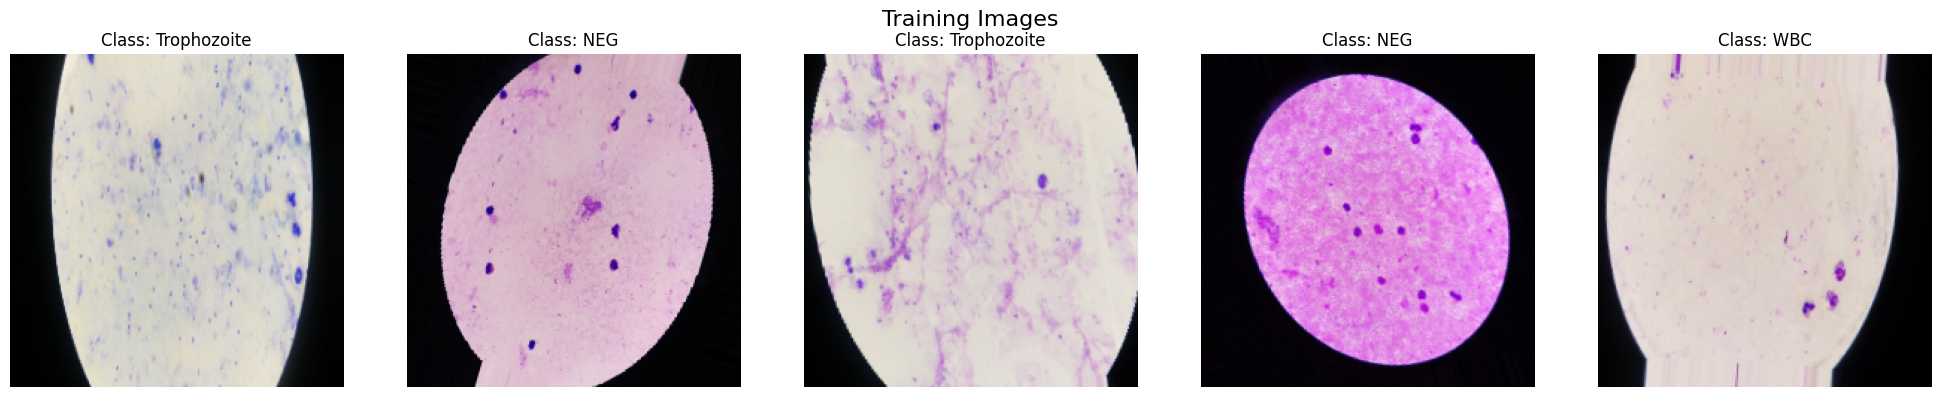

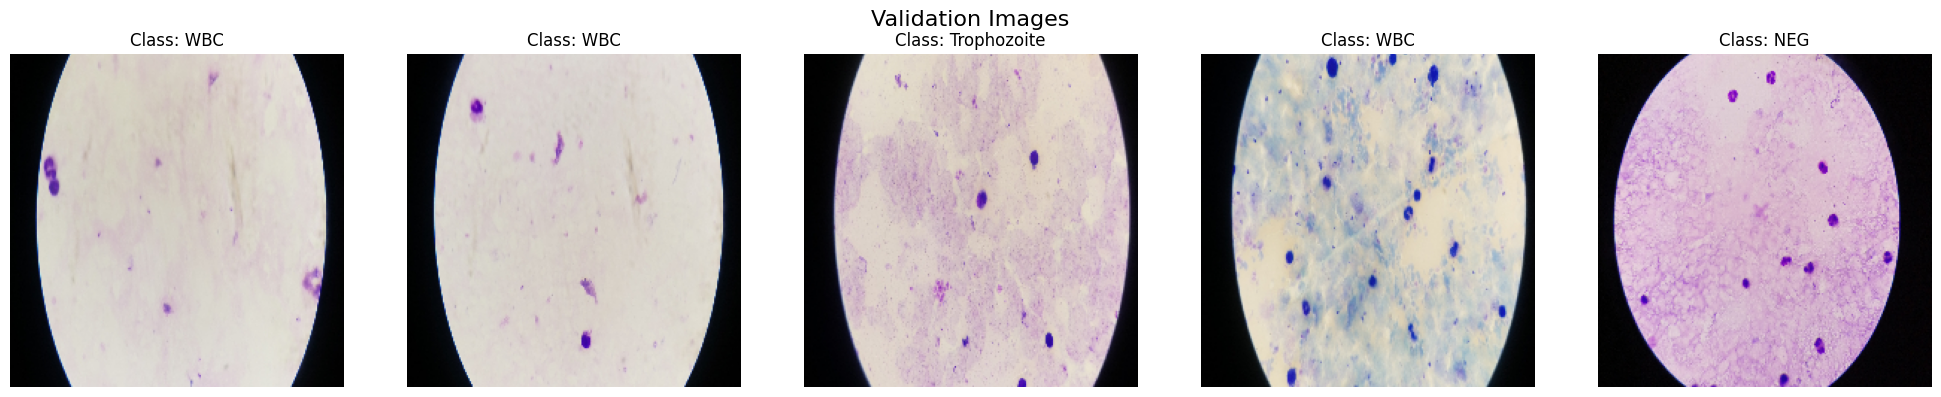

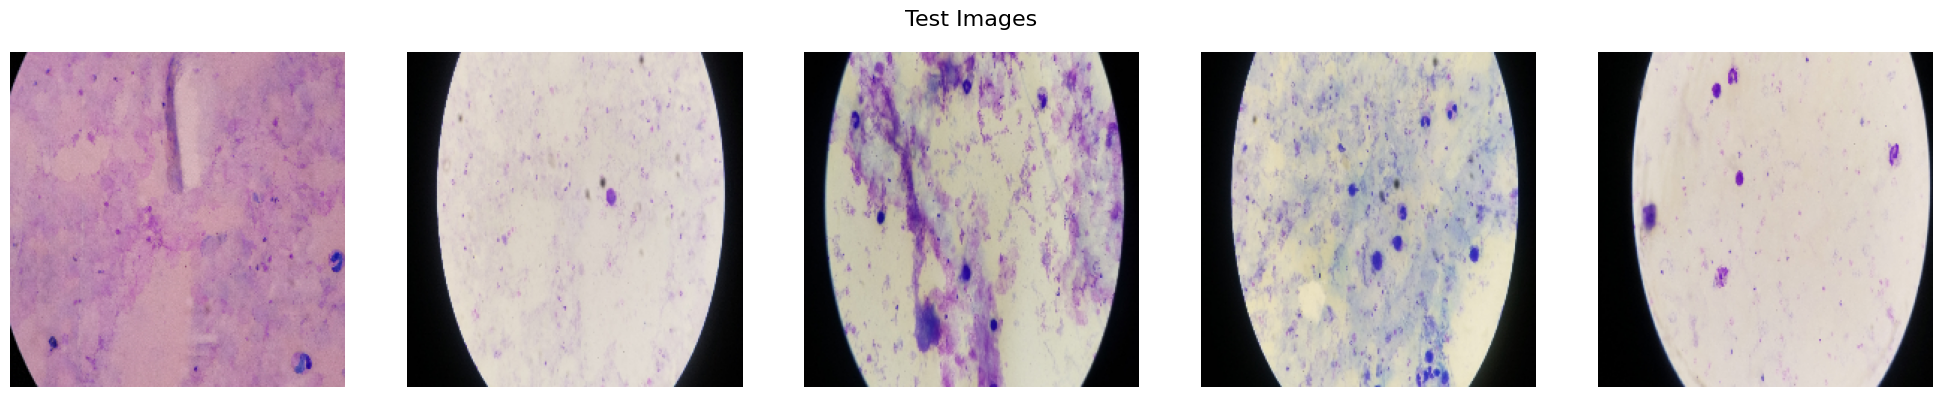

In [7]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def plot_images(generator, title, n=5):
    plt.figure(figsize=(20, 4))
    plt.suptitle(title, fontsize=16)
    
    # Check if the generator has class information
    has_classes = hasattr(generator, 'class_indices')
    
    if has_classes:
        # Get the class indices
        class_indices = generator.class_indices
        # Invert the dictionary to map indices to class names
        index_to_class = {v: k for k, v in class_indices.items()}
    
    for i in range(n):
        # Get a batch of images
        batch = next(generator)
        
        # For train and validation, batch is a tuple (images, labels)
        # For test, batch is just images
        if isinstance(batch, tuple):
            images, labels = batch
        else:
            images = batch
        
        # Select a random image from the batch
        idx = np.random.randint(0, images.shape[0])
        img = images[idx]
        
        plt.subplot(1, n, i+1)
        plt.imshow(img)
        plt.axis('off')
        
        if has_classes and isinstance(batch, tuple):
            label_idx = np.argmax(labels[idx])
            class_name = index_to_class[label_idx]
            plt.title(f"Class: {class_name}")
    
    plt.tight_layout()
    plt.show()

# Visualize training images
plot_images(train_generator, "Training Images")

# Visualize validation images
plot_images(val_generator, "Validation Images")

# Visualize test images
plot_images(test_generator, "Test Images")

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [9]:
# Define the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(3, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=0.0001)

In [11]:
# Train the model
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=val_generator,
    validation_steps=None,
    callbacks=[early_stopping, reduce_lr]
)

Epoch 1/50


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1728878032.450096      70 service.cc:145] XLA service 0x7c7b98004930 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1728878032.450148      70 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1728878032.450153      70 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 1/45 ━━━━━━━━━━━━━━━━━━━━ 21:02 29s/step - accuracy: 0.3125 - loss: 1.1094

I0000 00:00:1728878039.992464      70 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


45/45 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.4192 - loss: 1.0214 - val_accuracy: 0.6917 - val_loss: 0.6103 - learning_rate: 0.0010
Epoch 2/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.6109 - loss: 0.6584 - val_accuracy: 0.6861 - val_loss: 0.6104 - learning_rate: 0.0010
Epoch 3/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 98s 2s/step - accuracy: 0.6765 - loss: 0.5464 - val_accuracy: 0.7028 - val_loss: 0.5072 - learning_rate: 0.0010
Epoch 4/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.6455 - loss: 0.5268 - val_accuracy: 0.6389 - val_loss: 0.6254 - learning_rate: 0.0010
Epoch 5/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 95s 2s/step - accuracy: 0.6521 - loss: 0.5128 - val_accuracy: 0.7556 - val_loss: 0.5145 - learning_rate: 0.0010
Epoch 6/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.6689 - loss: 0.5600 - val_accuracy: 0.6194 - val_loss: 0.6894 - learning_rate: 0.0010
Epoch 7/50
45/45 ━━━━━━━━━━━━━━━━━━━━ 100s 2s/step - accuracy: 0.6911 - loss: 0.4885 - val_accuracy: 0.6556 - 

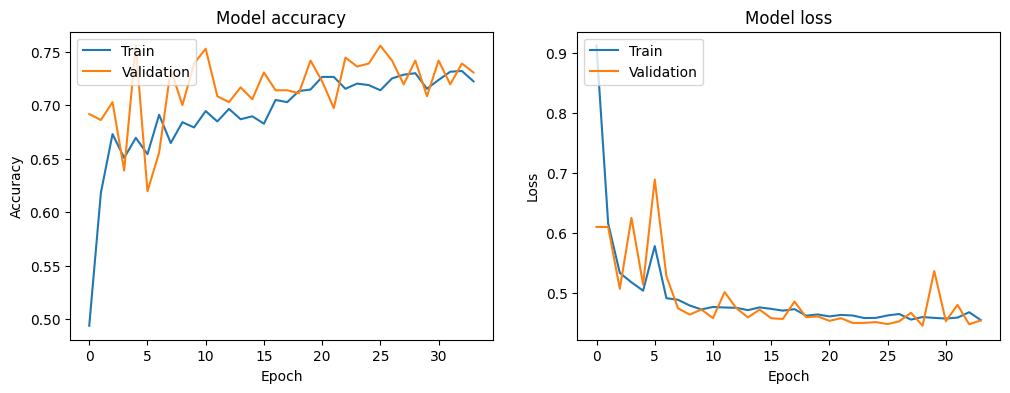

In [12]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

In [13]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(val_generator)
print(f"Test accuracy: {test_accuracy:.4f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 16s 1s/step - accuracy: 0.7212 - loss: 0.4632
Test accuracy: 0.7417


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 285ms/step


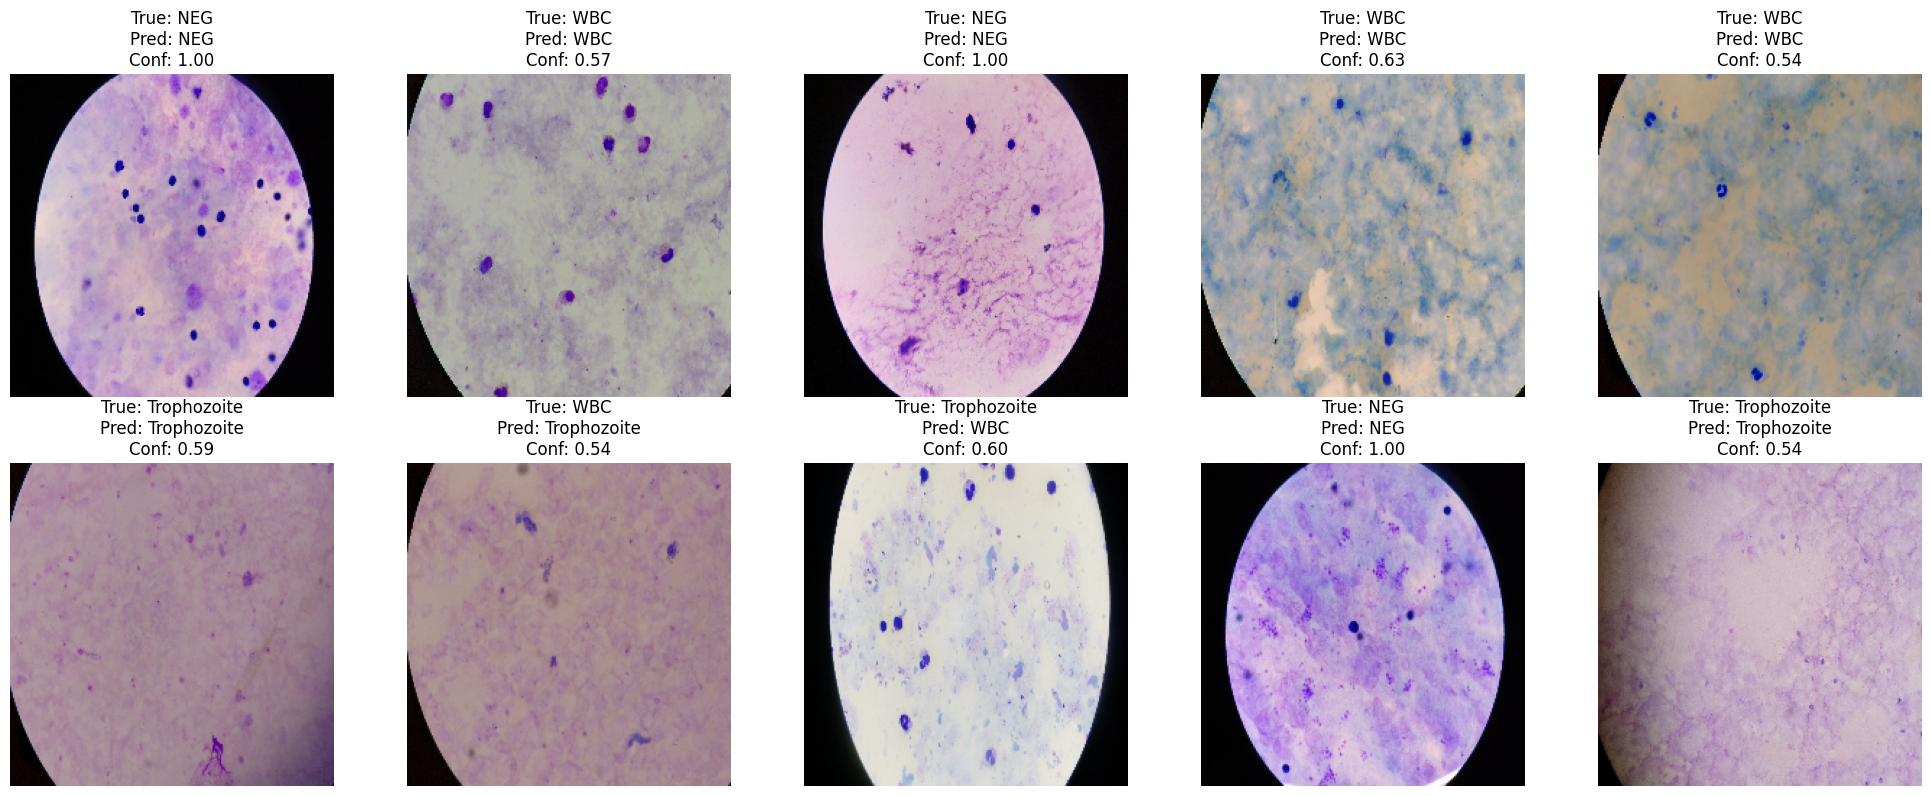

In [14]:
import random

def plot_sample_predictions(model, val_generator, val_data, num_samples=10):
    # Get a batch of validation data
    batch_x, batch_y = next(val_generator)
    
    # Get predictions
    predictions = model.predict(batch_x)
    
    # Get class labels
    class_labels = list(val_generator.class_indices.keys())
    
    # Randomly select samples
    indices = random.sample(range(len(batch_x)), num_samples)
    
    # Plot the samples
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.ravel()
    
    for i, idx in enumerate(indices):
        # Get the image and its true label
        img = batch_x[idx]
        true_label = class_labels[np.argmax(batch_y[idx])]
        
        # Get the predicted label and confidence
        pred_label = class_labels[np.argmax(predictions[idx])]
        confidence = np.max(predictions[idx])
        
        # Plot the image
        axes[i].imshow(img)
        axes[i].axis('off')
        axes[i].set_title(f"True: {true_label}\nPred: {pred_label}\nConf: {confidence:.2f}")
    
    plt.tight_layout()
    plt.show()

# Use the function
plot_sample_predictions(model, val_generator, val_data)

In [15]:
# Get predictions
predictions = model.predict(test_generator, steps=len(test_df) // batch_size + 1)

# Get class labels
class_labels = list(train_generator.class_indices.keys())

# Create a DataFrame with predictions
results_df = pd.DataFrame({
    'Image_ID': test_df['Image_ID'],
    'Predicted_Class': [class_labels[np.argmax(pred)] for pred in predictions],
    'Confidence': [np.max(pred) for pred in predictions]
})

37/37 ━━━━━━━━━━━━━━━━━━━━ 79s 2s/step


In [16]:
results_df.head()

Image_ID Predicted_Class  Confidence
0  id_5n9ov0rr22.jpg     Trophozoite    0.514168
1  id_k6s11k3klo.jpg     Trophozoite    0.508008
2  id_eftvcf9djb.jpg     Trophozoite    0.531548
3  id_kc5tmoj1xa.jpg     Trophozoite    0.539209
4  id_tirid4qt68.jpg     Trophozoite    0.533799